In [1]:
!pip install -U transformers datasets scikit-learn

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 22.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which 

Map:   0%|          | 0/1267 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-4-e93fc18acd69>:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=args, tokenizer=tokenizer)



LIAR — Best Threshold based on F1:
Threshold    0.100000
Precision    0.494810
Recall       0.636971
F1           0.556962
Accuracy     0.640884
Name: 0, dtype: float64


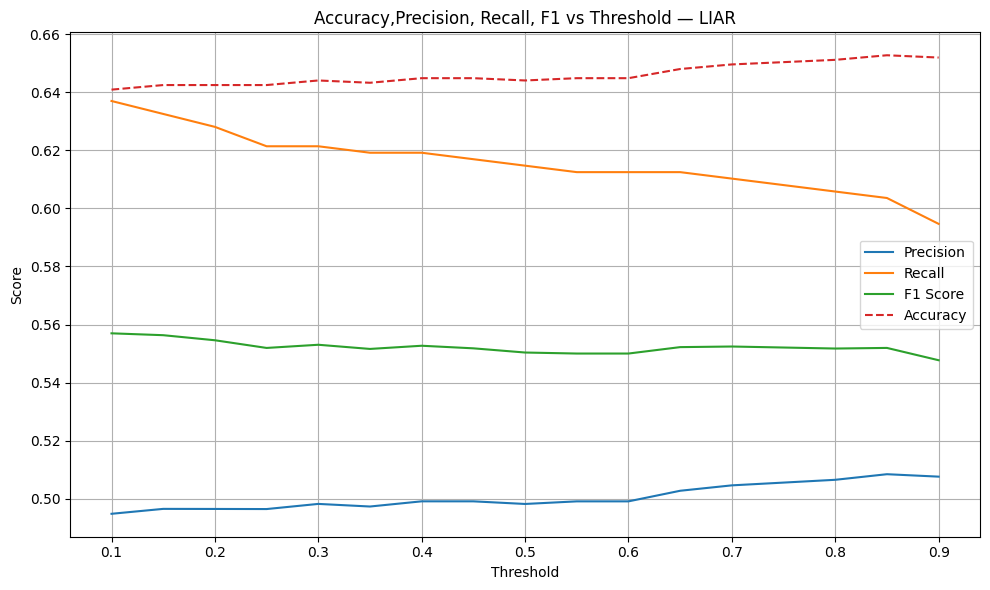

LIAR AUROC: 0.6813


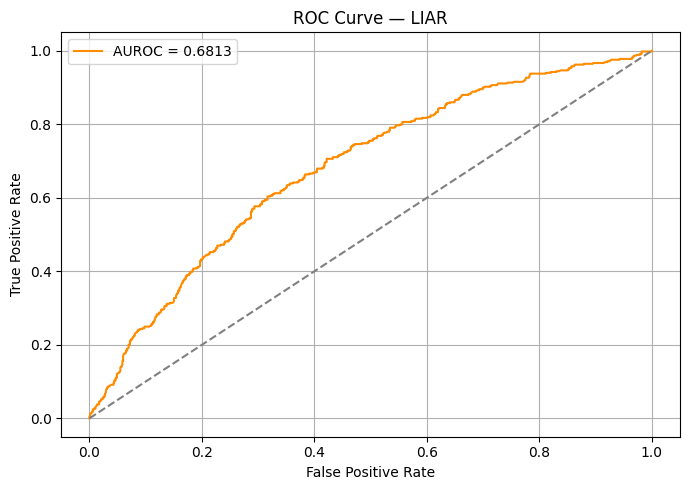

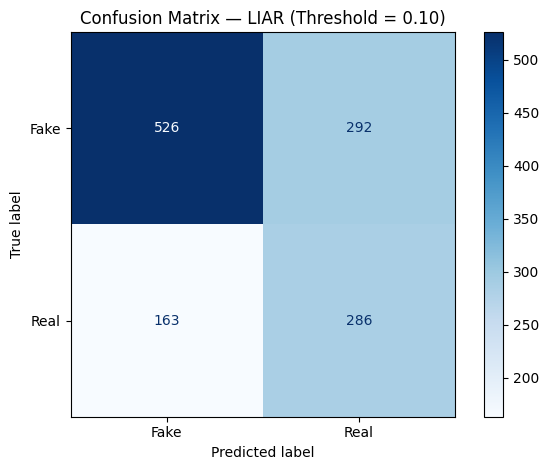

Map:   0%|          | 0/85 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-4-e93fc18acd69>:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=args, tokenizer=tokenizer)



FakeNewsNet — Best Threshold based on F1:
Threshold    0.150000
Precision    0.561644
Recall       0.976190
F1           0.713043
Accuracy     0.611765
Name: 1, dtype: float64


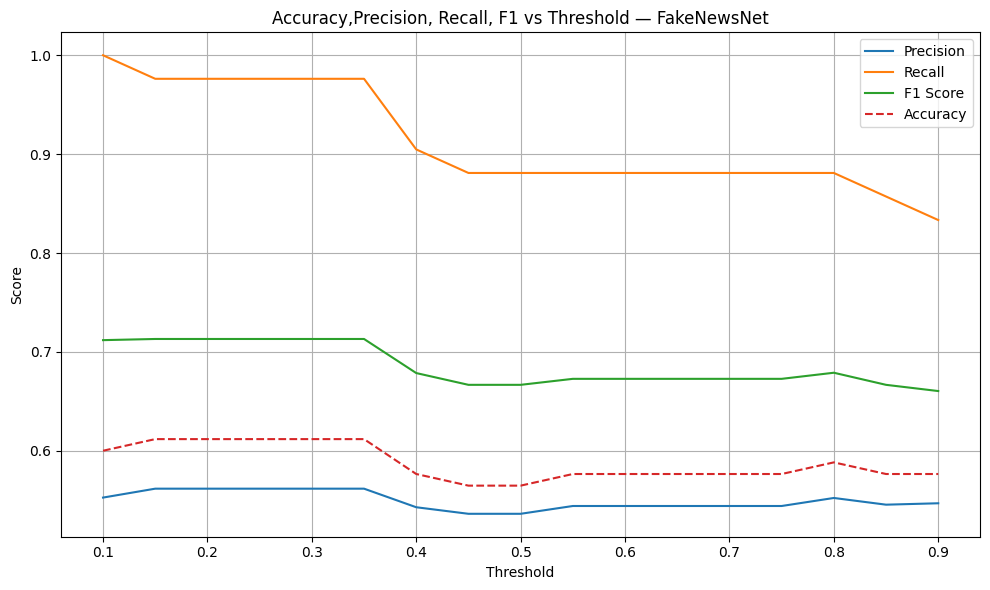

FakeNewsNet AUROC: 0.5030


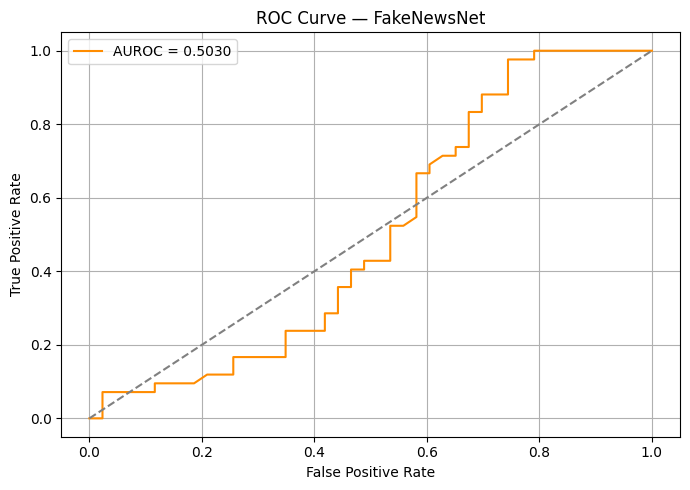

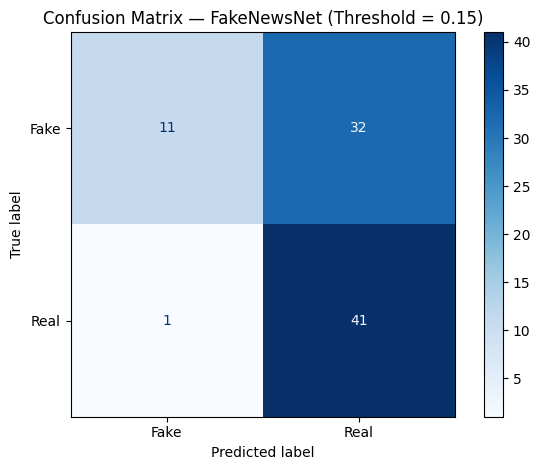

In [4]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
)

os.environ["WANDB_DISABLED"] = "true"

model_path = "/content/drive/MyDrive/misinfo_project/models/deberta_final"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.eval()


def evaluate_thresholds_and_roc(df_path, dataset_name):

    df = pd.read_csv(df_path).dropna(subset=["text", "label"])
    df["label"] = df["label"].astype(int)

    def tokenize(example):
        return tokenizer(example["text"], truncation=True, padding="max_length", max_length=256)

    dataset = Dataset.from_pandas(df).map(tokenize, batched=True)
    dataset = dataset.remove_columns(["text"])
    dataset.set_format("torch")

    args = TrainingArguments(output_dir="./eval_temp", per_device_eval_batch_size=4, fp16=True)
    trainer = Trainer(model=model, args=args, tokenizer=tokenizer)
    predictions = trainer.predict(dataset)

    probs = torch.softmax(torch.tensor(predictions.predictions), dim=1)[:, 1].numpy()
    labels = predictions.label_ids

    thresholds = np.arange(0.1, 0.95, 0.05)
    metrics = []

    for t in thresholds:
        preds = (probs >= t).astype(int)
        precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary", zero_division=0)
        acc = accuracy_score(labels, preds)
        metrics.append((t, precision, recall, f1, acc))

    df_metrics = pd.DataFrame(metrics, columns=["Threshold", "Precision", "Recall", "F1", "Accuracy"])
    best = df_metrics.iloc[df_metrics["F1"].idxmax()]
    best_threshold = best["Threshold"]

    print(f"\n{dataset_name} — Best Threshold based on F1:")
    print(best)

    plt.figure(figsize=(10, 6))
    plt.plot(df_metrics["Threshold"], df_metrics["Precision"], label="Precision")
    plt.plot(df_metrics["Threshold"], df_metrics["Recall"], label="Recall")
    plt.plot(df_metrics["Threshold"], df_metrics["F1"], label="F1 Score")
    plt.plot(df_metrics["Threshold"], df_metrics["Accuracy"], label="Accuracy", linestyle="--")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title(f"Accuracy,Precision, Recall, F1 vs Threshold — {dataset_name}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    auroc = roc_auc_score(labels, probs)
    fpr, tpr, _ = roc_curve(labels, probs)

    print(f"{dataset_name} AUROC: {auroc:.4f}")

    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, label=f"AUROC = {auroc:.4f}", color="darkorange")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve — {dataset_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    best_preds = (probs >= best_threshold).astype(int)
    cm = confusion_matrix(labels, best_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix — {dataset_name} (Threshold = {best_threshold:.2f})")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

evaluate_thresholds_and_roc("/content/drive/MyDrive/misinfo_project/liar/liar_test.csv", "LIAR")
evaluate_thresholds_and_roc("/content/drive/MyDrive/misinfo_project/fakenewsnet/fakenewsnet_test.csv", "FakeNewsNet")
